# Jordan Torres ML Final
Following along from a TensorFlow tutorial I was able to apply what I've learned from class to attempt a housing price prediction based on the Kings City Dataset. Using this data set I will seperate features trying to predict housing prices by square footage.

In [1]:
pip install -q seaborn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.6.0


In [4]:
df = pd.read_csv('/content/kc_house_data.csv')
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [5]:
dataset = df.copy()
dataset.tail()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287
21612,1523300157,20141015T000000,325000.0,2,0.75,1020,1076,2.0,0,0,3,7,1020,0,2008,0,98144,47.5941,-122.299,1020,1357


In [6]:
#train the model with 80% of the data
train_dataset = dataset.sample(frac=0.8, random_state=0)
#to see how well it does with other 20% of the data
test_dataset = dataset.drop(train_dataset.index)

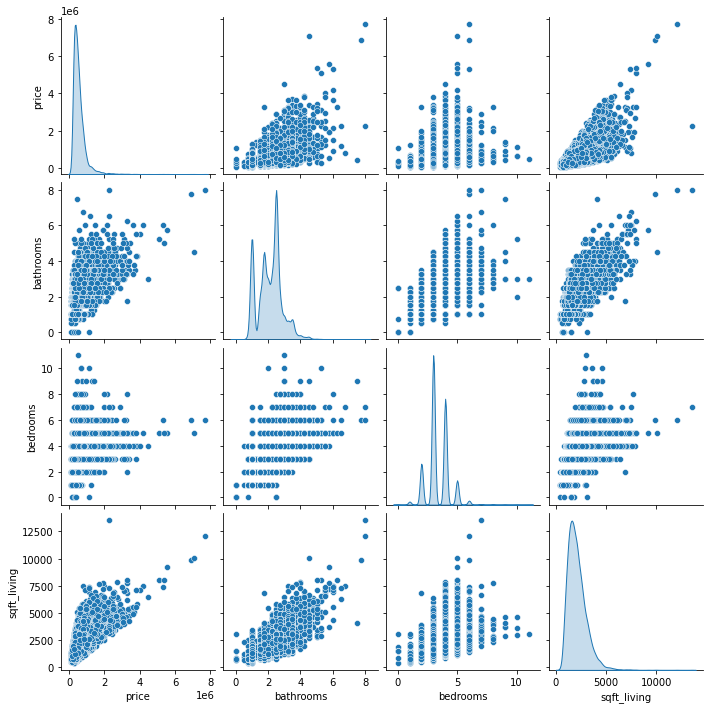

In [7]:
sns.pairplot(train_dataset[['price', 'bathrooms', 'bedrooms', 'sqft_living']], diag_kind='kde')

In [8]:
#describing the the totals and other forms of averages. Transpose = makes the rows columns and the columns rows
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,17290.0,4.574797e+09,2.878860e+09,1.200019e+06,2.115510e+09,3.897100e+09,7.308825e+09,9.900000e+09
price,17290.0,5.407489e+05,3.704495e+05,7.500000e+04,3.201500e+05,4.500000e+05,6.450000e+05,7.700000e+06
bedrooms,17290.0,3.373684e+00,9.045046e-01,0.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,1.100000e+01
bathrooms,17290.0,2.113924e+00,7.669899e-01,0.000000e+00,1.750000e+00,2.250000e+00,2.500000e+00,8.000000e+00
sqft_living,17290.0,2.081447e+03,9.210163e+02,3.700000e+02,1.430000e+03,1.910000e+03,2.550000e+03,1.354000e+04
sqft_lot,17290.0,1.511112e+04,4.036823e+04,5.200000e+02,5.040000e+03,7.620000e+03,1.066325e+04,1.164794e+06
floors,17290.0,1.493667e+00,5.399509e-01,1.000000e+00,1.000000e+00,1.500000e+00,2.000000e+00,3.500000e+00
waterfront,17290.0,7.634471e-03,8.704380e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
view,17290.0,2.380567e-01,7.737285e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
condition,17290.0,3.408502e+00,6.510291e-01,1.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00


In [9]:
#Separate the target value, the "label", from the features. This label is the value that you will train the model to predict
train_features = train_dataset.copy().drop(['date'], axis=1)
test_features = test_dataset.copy().drop(['date'], axis=1)

# This label is what the model will predict. In our case, price.
train_labels = train_features.pop('price')
test_labels = test_features.pop('price')

train_features = train_features[["sqft_living", "bedrooms", "bathrooms"]]
test_features = test_features[["sqft_living", "bedrooms", "bathrooms"]]
print(train_features)

       sqft_living  bedrooms  bathrooms
17384         1430         2       1.50
722           4670         4       3.25
2680          1440         2       0.75
18754         1130         2       1.00
14554         3180         4       2.50
...            ...       ...        ...
7372          2470         6       3.00
8118          1220         3       2.00
16465         1910         4       2.75
16197         2600         4       2.75
17185         1630         3       1.50

[17290 rows x 3 columns]


In [10]:
# stats to show the range for differnet features 
train_features.describe().transpose()[['mean', 'std']]

,mean,std
sqft_living,2081.447368,921.016255
bedrooms,3.373684,0.904505
bathrooms,2.113924,0.766990


In [26]:
#The preprocessing.Normalization layer is a clean and simple way to build that preprocessing into your model.
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
# This calculates the mean and variance, and stores them in the layer.
print(normalizer.mean.numpy())


[[2081.447    3.374    2.114]]


In [12]:
# When the layer is called it returns the input data, with each feature independently normalized:
first = np.array(train_features['sqft_living'][:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())


First example: [1430]

Normalized: [[  -0.71 1577.29 1861.73]]


In [13]:
price_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

price_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 3)                 7         
_________________________________________________________________
dense (Dense)                (None, 1)                 4         
Total params: 11
Trainable params: 4
Non-trainable params: 7
_________________________________________________________________


In [28]:
# DNN Regression solution rather than linear model. I am going to see if added hidden layers improve our prediction!
def build_and_compile_model(norm):
    model = keras.Sequential([
    norm,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)])

    model.compile(loss='mean_absolute_error',
    optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [29]:
dnn_pricing_model = build_and_compile_model(normalizer)
dnn_pricing_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,488
Trainable params: 4,481
Non-trainable params: 7
_________________________________________________________________


In [35]:
%%time
predict_model = dnn_pricing_model.fit(
  train_features['sqft_living'], train_labels,
  validation_split=0.2,
  verbose=0, epochs=100)

CPU times: user 2min 14s, sys: 17.5 s, total: 2min 32s
Wall time: 2min 21s


In [36]:
hist = pd.DataFrame(predict_model.history)
hist['epoch'] = predict_model.epoch
hist.tail()

,loss,val_loss,epoch
95,167074.62500,170840.843750,95
96,167161.46875,170819.578125,96
97,167032.28125,170635.578125,97
98,166972.40625,170633.531250,98
99,167014.81250,170716.421875,99


In [37]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 1000000])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Price]')
    plt.legend()
    plt.grid(True)

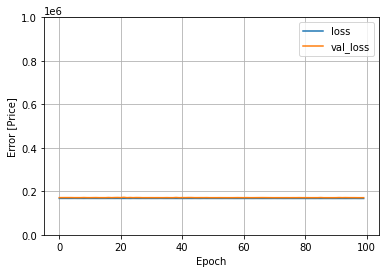

In [38]:
plot_loss(predict_model)

In [39]:
def plot_sqft_living(x, y):
  plt.scatter(train_features["sqft_living"], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Sq Feet')
  plt.ylabel('Price')
  plt.legend()

In [40]:
x = tf.linspace(0.0, 250, 251)
y = dnn_pricing_model.predict(x)

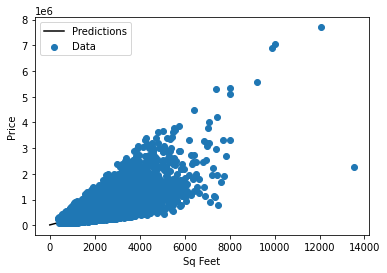

In [41]:
plot_sqft_living(x, y)

What I can surmise from this project was that I needed more data to get better results for my model. It was intersting finding ways to optimize and push this model into where it could accurately predict housing prices based of square feet.